In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=1.5)

from keras_radam import RAdam

Using TensorFlow backend.


# 전처리

In [2]:
student = pd.read_csv('../student/student-mat.csv')

In [3]:
student.isnull().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

In [4]:
student.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        395 non-null object
sex           395 non-null object
age           395 non-null int64
address       395 non-null object
famsize       395 non-null object
Pstatus       395 non-null object
Medu          395 non-null int64
Fedu          395 non-null int64
Mjob          395 non-null object
Fjob          395 non-null object
reason        395 non-null object
guardian      395 non-null object
traveltime    395 non-null int64
studytime     395 non-null int64
failures      395 non-null int64
schoolsup     395 non-null object
famsup        395 non-null object
paid          395 non-null object
activities    395 non-null object
nursery       395 non-null object
higher        395 non-null object
internet      395 non-null object
romantic      395 non-null object
famrel        395 non-null int64
freetime      395 non-null int64
goout         395 non-null int64
Dalc          395 no

In [5]:
print(student.Mjob.unique())
print(student.Fjob.unique())

['at_home' 'health' 'other' 'services' 'teacher']
['teacher' 'other' 'services' 'health' 'at_home']


In [6]:
student['internet']

0       no
1      yes
2      yes
3      yes
4       no
      ... 
390     no
391    yes
392     no
393    yes
394    yes
Name: internet, Length: 395, dtype: object

## ColumnTransformer

In [7]:
import sklearn
sklearn.__version__

'0.21.3'

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer

In [9]:
ct = ColumnTransformer([('scaling', Normalizer(),  ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 
                                                        'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']),
                       ('onehot', OneHotEncoder(sparse = False),
                       ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'guardian','schoolsup', 'famsup', 'paid', 'activities', 
             'nursery', 'higher', 'internet', 'romantic'  ])]    )

In [10]:
student.drop('reason', axis = 1, inplace = True)

In [11]:
student['aver'] =( student['G1'] + student['G2'] + student['G3']) / 3

In [12]:
# upper 90% : "A", 70% to 90% : "B", else "C"
def grade(score):
    if score >= 18:
        return 'A'
    elif score >= 14:
        return 'B'
    else:
        return 'C'

In [13]:
student['grade'] = student['aver'].map(grade)

In [14]:
X, y = (student.drop(['G1', 'G2', 'G3','aver', 'grade'], axis = 1)), student.grade

In [91]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10, test_size = 0.2)

In [16]:
X_train_trans = ct.fit_transform(X_train)
X_test_trans = ct.transform(X_test)

# 범주형 데이터로 나누지 않은

In [17]:
student['school']= student.school.map({'GP' : 0, 'MS' :  1})
student.sex = student.sex.map({'F' : 0, 'M' :  1})
student.address = student.address.map({'U' : 0, 'R' :  1})
student.famsize = student.famsize.map({'LE3' : 0, 'GT3' :  1})
student.Pstatus = student.Pstatus.map({'T' : 0, 'A' :  1})
student.Mjob = student.Mjob.map({'at_home' : 0, 'health' :  1, 'other' : 2, 'services' : 3, 'teacher' : 4})
student.Fjob= student.Fjob.map({'at_home' : 0, 'health' :  1, 'other' : 2, 'services' : 3, 'teacher' : 4})
student.guardian = student.guardian.map({'mother' : 0, 'father' :  1, 'other' : 2})

In [18]:
col_names = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

for i in col_names:
    student[i]= student[i].map({'yes' : 0, 'no' :  1})

In [19]:
student.describe()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,aver
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,...,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,0.116456,0.473418,16.696203,0.222785,0.711392,0.103797,2.749367,2.521519,2.169620,2.281013,...,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190,10.679325
std,0.321177,0.499926,1.276043,0.416643,0.453690,0.305384,1.094735,1.088201,1.227473,0.863542,...,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443,3.696786
min,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000,1.333333
25%,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,...,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000,8.333333
50%,0.000000,0.000000,17.000000,0.000000,1.000000,0.000000,3.000000,2.000000,2.000000,2.000000,...,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000,10.666667
75%,0.000000,1.000000,18.000000,0.000000,1.000000,0.000000,4.000000,3.000000,3.000000,3.000000,...,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000,13.333333
max,1.000000,1.000000,22.000000,1.000000,1.000000,1.000000,4.000000,4.000000,4.000000,4.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000,19.333333


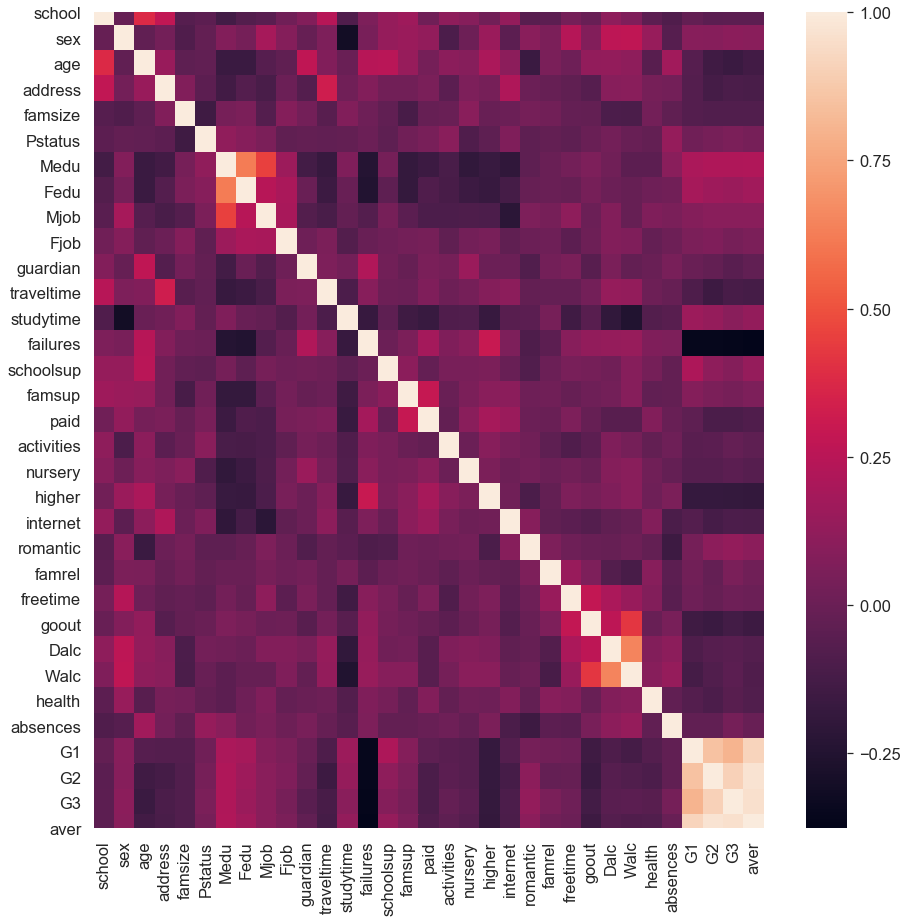

In [20]:
graph = student.corr()
plt.figure(figsize= (15, 15))
sns.heatmap(graph)

In [21]:
X, y = (student.drop(['G1', 'G2', 'G3','aver', 'grade'], axis = 1)), student.grade

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10, test_size = 0.2)

# Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


In [24]:
param_grid = {'n_estimators' : np.arange(10, 101, 10)}
print("parameter: \n", param_grid)

parameter: 
 {'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])}


In [25]:
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv = 5, return_train_score = True)

In [26]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [27]:
grid_search.score(X_test, y_test)

0.8354430379746836

In [28]:
print("최고 교차 검증 점수: ", grid_search.best_score_)
print("최적 매개변수 : ", grid_search.best_params_)

최고 교차 검증 점수:  0.810126582278481
최적 매개변수 :  {'n_estimators': 70}


## column transfer - Randomforest

In [29]:
param_grid = {'n_estimators' : np.arange(10, 101, 10)}
print("parameter: \n", param_grid)

parameter: 
 {'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])}


In [30]:
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv = 5, return_train_score = True)

In [31]:
grid_search.fit(X_train_trans, y_train)

C:\Users\ORC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [32]:
grid_search.score(X_test_trans, y_test)

0.8354430379746836

In [33]:
print("최고 교차 검증 점수: ", grid_search.best_score_)
print("최적 매개변수 : ", grid_search.best_params_)

최고 교차 검증 점수:  0.8069620253164557
최적 매개변수 :  {'n_estimators': 70}


# 

# Decision Tree

In [34]:
from sklearn.tree import DecisionTreeClassifier

In [35]:
param_grid = {'max_depth' : np.arange(1, 6)}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 5 , return_train_score = True)
grid_search.fit(X_train, y_train)

C:\Users\ORC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': array([1, 2, 3, 4, 5])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True

In [36]:
grid_search.score(X_test, y_test)

0.8227848101265823

In [37]:
print("최고 교차 검증 점수: ", grid_search.best_score_)
print("최적 매개변수: ", grid_search.best_params_)

최고 교차 검증 점수:  0.7879746835443038
최적 매개변수:  {'max_depth': 1}


## column transfer - DecisionTree

In [38]:
param_grid = {'max_depth' : np.arange(1, 6)}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 5 , return_train_score = True)
grid_search.fit(X_train_trans, y_train)

C:\Users\ORC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': array([1, 2, 3, 4, 5])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True

In [39]:
grid_search.score(X_test_trans, y_test)

0.8227848101265823

In [40]:
print("최고 교차 검증 점수: ", grid_search.best_score_)
print("최적 매개변수: ", grid_search.best_params_)

최고 교차 검증 점수:  0.7721518987341772
최적 매개변수:  {'max_depth': 1}


### 123

# SVM

In [41]:
from sklearn.svm import SVC

In [42]:
param_grid = {'gamma' : [0.001, 0.01, 0.1, 1, 10, 100], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(SVC(), param_grid, cv = 5 , return_train_score = True)
grid_search.fit(X_train, y_train)

C:\Users\ORC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [43]:
grid_search.score(X_test, y_test)

0.8227848101265823

In [44]:
print("최고 교차 검증 점수: ", grid_search.best_score_)
print("최적 매개변수: ", grid_search.best_params_)

최고 교차 검증 점수:  0.7879746835443038
최적 매개변수:  {'C': 0.001, 'gamma': 0.001}


## column transfer - SVM

In [45]:
param_grid = {'gamma' : [0.001, 0.01, 0.1, 1, 10, 100], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(SVC(), param_grid, cv = 5 , return_train_score = True)
grid_search.fit(X_train_trans, y_train)

C:\Users\ORC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [46]:
grid_search.score(X_test_trans, y_test)

0.8227848101265823

In [47]:
print("최고 교차 검증 점수: ", grid_search.best_score_)
print("최적 매개변수: ", grid_search.best_params_)

최고 교차 검증 점수:  0.7879746835443038
최적 매개변수:  {'C': 0.001, 'gamma': 0.001}


# GBRT

In [48]:
from sklearn.ensemble import GradientBoostingClassifier

In [49]:
param_grid = {'max_depth' : np.arange(1, 6)}

grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv = 5 , return_train_score = True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

In [50]:
grid_search.score(X_test, y_test)

0.8354430379746836

In [51]:
print("최고 교차 검증 점수: ", grid_search.best_score_)
print("최적 매개변수: ", grid_search.best_params_)

최고 교차 검증 점수:  0.7753164556962026
최적 매개변수:  {'max_depth': 1}


## column transfer - GBRT

In [52]:
param_grid = {'max_depth' : np.arange(1, 6)}

grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv = 5 , return_train_score = True)
grid_search.fit(X_train_trans, y_train)

C:\Users\ORC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

In [53]:
grid_search.score(X_test_trans, y_test)

0.8354430379746836

In [54]:
print("최고 교차 검증 점수: ", grid_search.best_score_)
print("최적 매개변수: ", grid_search.best_params_)

최고 교차 검증 점수:  0.759493670886076
최적 매개변수:  {'max_depth': 1}


# KNN

In [55]:
from sklearn.neighbors import KNeighborsClassifier

In [56]:
param_grid = {'n_neighbors' : np.arange(1, 10)}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv = 5 , return_train_score = True)
grid_search.fit(X_train, y_train)

C:\Users\ORC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [57]:
grid_search.score(X_test, y_test)

0.759493670886076

In [58]:
print("최고 교차 검증 점수: ", grid_search.best_score_)
print("최적 매개변수: ", grid_search.best_params_)

최고 교차 검증 점수:  0.7784810126582279
최적 매개변수:  {'n_neighbors': 7}


## column transfer -KNN

In [59]:
param_grid = {'n_neighbors' : np.arange(1, 10)}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv = 5 , return_train_score = True)
grid_search.fit(X_train_trans, y_train)

C:\Users\ORC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [60]:
grid_search.score(X_test_trans, y_test)

0.8227848101265823

In [61]:
print("최고 교차 검증 점수: ", grid_search.best_score_)
print("최적 매개변수: ", grid_search.best_params_)

최고 교차 검증 점수:  0.7753164556962026
최적 매개변수:  {'n_neighbors': 7}


# PCA

In [62]:
from sklearn.decomposition import PCA

In [63]:
best_comp = ['n']
best_score = 0
best_knn = None

for n, i in enumerate(range(1, 14)):
    pca = PCA(n_components= i).fit(X_train_trans)
    X_train_pca = pca.transform(X_train_trans)
    X_test_pca = pca.transform(X_test_trans)
    
    param_grid = {'n_neighbors' : np.arange(1, 10)}

    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv = 5 , return_train_score = True)
    grid_search.fit(X_train_pca, y_train)
    
    if grid_search.best_score_ > best_score :
        best_score = grid_search.best_score_
        best_knn = KNeighborsClassifier(param_grid)
        best_comp[0] = n

    print("{}_component에서 테스트셋 점수".format(n+1), grid_search.score(X_test_pca, y_test))

    print("최고 교차 검증 점수: ", grid_search.best_score_)
    print("최적 매개변수: ", grid_search.best_params_, "\n")

C:\Users\ORC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


1_component에서 테스트셋 점수 0.7974683544303798
최고 교차 검증 점수:  0.7689873417721519
최적 매개변수:  {'n_neighbors': 9} 



C:\Users\ORC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


2_component에서 테스트셋 점수 0.810126582278481
최고 교차 검증 점수:  0.7721518987341772
최적 매개변수:  {'n_neighbors': 9} 



C:\Users\ORC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


3_component에서 테스트셋 점수 0.7974683544303798
최고 교차 검증 점수:  0.7816455696202531
최적 매개변수:  {'n_neighbors': 7} 



C:\Users\ORC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


4_component에서 테스트셋 점수 0.7974683544303798
최고 교차 검증 점수:  0.7721518987341772
최적 매개변수:  {'n_neighbors': 9} 



C:\Users\ORC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


5_component에서 테스트셋 점수 0.7721518987341772
최고 교차 검증 점수:  0.7753164556962026
최적 매개변수:  {'n_neighbors': 7} 



C:\Users\ORC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


6_component에서 테스트셋 점수 0.810126582278481
최고 교차 검증 점수:  0.7721518987341772
최적 매개변수:  {'n_neighbors': 9} 

7_component에서 테스트셋 점수 0.7848101265822784
최고 교차 검증 점수:  0.7658227848101266
최적 매개변수:  {'n_neighbors': 9} 



C:\Users\ORC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\ORC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


8_component에서 테스트셋 점수 0.810126582278481
최고 교차 검증 점수:  0.759493670886076
최적 매개변수:  {'n_neighbors': 9} 



C:\Users\ORC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


9_component에서 테스트셋 점수 0.810126582278481
최고 교차 검증 점수:  0.7626582278481012
최적 매개변수:  {'n_neighbors': 9} 



C:\Users\ORC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


10_component에서 테스트셋 점수 0.7974683544303798
최고 교차 검증 점수:  0.759493670886076
최적 매개변수:  {'n_neighbors': 9} 



C:\Users\ORC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


11_component에서 테스트셋 점수 0.7974683544303798
최고 교차 검증 점수:  0.759493670886076
최적 매개변수:  {'n_neighbors': 9} 



C:\Users\ORC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


12_component에서 테스트셋 점수 0.7848101265822784
최고 교차 검증 점수:  0.759493670886076
최적 매개변수:  {'n_neighbors': 9} 

13_component에서 테스트셋 점수 0.7848101265822784
최고 교차 검증 점수:  0.7531645569620253
최적 매개변수:  {'n_neighbors': 9} 



C:\Users\ORC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [64]:
print("{}_component에서 최고 교차검증 점수 : {} \n 최적 knn model: {}".format(best_comp, best_score, best_knn))

[2]_component에서 최고 교차검증 점수 : 0.7816455696202531 
 최적 knn model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None,
                     n_neighbors={'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
                     p=2, weights='uniform')


# Select From Model

In [65]:
from sklearn.feature_selection import SelectFromModel

In [66]:
select = SelectFromModel(RandomForestClassifier(n_estimators = 100, random_state = 100), threshold = 'median')

In [67]:
select.fit(X_train, y_train)
X_train_sel = select.transform(X_train)
X_test_sel = select.transform(X_test)

In [68]:
param_grid = {'n_neighbors' : np.arange(1, 10)}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv = 5 , return_train_score = True)
grid_search.fit(X_train_sel, y_train)

C:\Users\ORC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [69]:
grid_search.score(X_test_sel, y_test)

0.810126582278481

In [70]:
print("최고 교차 검증 점수: ", grid_search.best_score_)
print("최적 매개변수: ", grid_search.best_params_)

최고 교차 검증 점수:  0.7753164556962026
최적 매개변수:  {'n_neighbors': 9}


#  CNN

In [90]:
X_train.shape

(316, 29)

In [72]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adam ,RMSprop 
from keras.utils import np_utils
from keras.utils import to_categorical

In [93]:
y_train = y_train.map({'A' : 0, "B" : 1 , "C" : 2})
y_test = y_test.map({'A' : 0, "B" : 1 , "C" : 2})

In [74]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

y_train = np_utils.to_categorical(y_train)
y_test  = np_utils.to_categorical(y_test)

In [75]:
from keras import layers
from keras import models

# 모델 구조 정의하기
model = Sequential()
model.add(Dense(19, input_shape=(29,)))
model.add(Activation('relu'))
model.add(Dense(13))
model.add(Activation('relu'))
model.add(Dense(7))
model.add(Activation('relu'))
model.add(Dense(3))
model.add(Activation('softmax'))

In [76]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 19)                570       
_________________________________________________________________
activation_1 (Activation)    (None, 19)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 13)                260       
_________________________________________________________________
activation_2 (Activation)    (None, 13)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 98        
_________________________________________________________________
activation_3 (Activation)    (None, 7)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 24        
__________

In [77]:
import tensorflow as tf
optimizer = tf.train.RMSPropOptimizer(learning_rate=0.006)

In [79]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train, y_train, epochs=15 )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch 1/15
316/316 [==============================] - 1s 3ms/step - loss: 2.0767 - acc: 0.2089
Epoch 2/15
316/316 [==============================] - 0s 35us/step - loss: 1.1395 - acc: 0.6234
Epoch 3/15
316/316 [==============================] - 0s 51us/step - loss: 1.0324 - acc: 0.7595
Epoch 4/15
316/316 [==============================] - 0s 35us/step - loss: 0.9437 - acc: 0.7848
Epoch 5/15
316/316 [==============================] - 0s 38us/step - loss: 0.7439 - acc: 0.7880
Epoch 6/15
316/316 [==============================] - 0s 139us/step - loss: 0.6145 - acc: 0.7880
Epoch 7/15
316/316 [==============================] - 0s 54us/step - loss: 0.5945 - acc: 0.7880
Epoch 8/15
316/316 [==============================] - 0s 41us/step - loss: 0.5919 - acc: 0.7880
Epoch 9/15
316/316 

In [80]:
score = model.evaluate(X_test, y_test, verbose=2)
print('loss=', score[0])
print('accuracy=', score[1])

loss= 0.531330843515034
accuracy= 0.8227848123900497


# optimizer - RAdam

In [105]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10, test_size = 0.2)

In [106]:
y_train = y_train.map({'A' : 0, "B" : 1 , "C" : 2})
y_test = y_test.map({'A' : 0, "B" : 1 , "C" : 2})

In [107]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

y_train = np_utils.to_categorical(y_train)
y_test  = np_utils.to_categorical(y_test)

In [108]:
from keras import layers
from keras import models

# 모델 구조 정의하기
model = Sequential()
model.add(Dense(19, input_shape=(29,)))
model.add(Activation('relu'))
model.add(Dense(13))
model.add(Activation('relu'))
model.add(Dense(7))
model.add(Activation('relu'))
model.add(Dense(3))
model.add(Activation('softmax'))

In [109]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 19)                570       
_________________________________________________________________
activation_13 (Activation)   (None, 19)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 13)                260       
_________________________________________________________________
activation_14 (Activation)   (None, 13)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 7)                 98        
_________________________________________________________________
activation_15 (Activation)   (None, 7)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 24        
__________

In [113]:
model.compile(optimizer=RAdam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [118]:
hist = model.fit(X_train, y_train, epochs=20 )

Epoch 1/20
316/316 [==============================] - 0s 38us/step - loss: 0.5773 - acc: 0.7880
Epoch 2/20
316/316 [==============================] - 0s 41us/step - loss: 0.5764 - acc: 0.7880
Epoch 3/20
316/316 [==============================] - 0s 146us/step - loss: 0.5761 - acc: 0.7880
Epoch 4/20
316/316 [==============================] - 0s 41us/step - loss: 0.5748 - acc: 0.7880
Epoch 5/20
316/316 [==============================] - 0s 57us/step - loss: 0.5740 - acc: 0.7880
Epoch 6/20
316/316 [==============================] - 0s 44us/step - loss: 0.5730 - acc: 0.7880
Epoch 7/20
316/316 [==============================] - 0s 85us/step - loss: 0.5720 - acc: 0.7880
Epoch 8/20
316/316 [==============================] - 0s 38us/step - loss: 0.5714 - acc: 0.7880
Epoch 9/20
316/316 [==============================] - 0s 73us/step - loss: 0.5706 - acc: 0.7880
Epoch 10/20
316/316 [==============================] - 0s 111us/step - loss: 0.5691 - acc: 0.7880
Epoch 11/20
316/316 [================

In [119]:
score = model.evaluate(X_test, y_test, verbose=2)
print('loss=', score[0])
print('accuracy=', score[1])

loss= 0.5382643583454664
accuracy= 0.8227848123900497
